# Tarea 3 - Optimización
- Integrantes: 
    - Samuel Coña J. - 
    - Daniel Lopez B. -
    - Dayan Sáez C. -
    - Luis Valenzuela C. - 2020437548

Instancia a resolver:

<table>
  <tr>
    <th></th>
    <th colspan="4">
      Máquinas r</th>
  </tr>
  <tr>
    <th>Trabajo i</th>
    <th>M<sub>1</th>
    <th>M<sub>2</th>
    <th>M<sub>3</th>
    <th>M<sub>4</th>
  </tr>
  <tr>
    <th>J<sub>1</th>
    <th>9</th>
    <th>13</th>
    <th>15</th>
    <th>20</th>
  </tr>
  <tr>
    <th>J<sub>2</th>
    <th>11</th>
    <th>17</th>
    <th>18</th>
    <th>24</th>
  </tr>
  <tr>
    <th>J<sub>3</th>
    <th>8</th>
    <th>12</th>
    <th>14</th>
    <th>18</th>
  </tr>
  <tr>
    <th>J<sub>4</th>
    <th>6</th>
    <th>10</th>
    <th>12</th>
    <th>15</th>
  </tr>

In [68]:
T = [[9,13,15,20],
     [11,17,18,24],
     [8,12,14,18],
     [6,10,12,15]]

### Párametros de los modelos


### Modelo Wagner

$$ Min \quad C_{max} = C_{MN} $$
$$ \sum_{j=1}^{N} Z_{ij} = 1; \quad (1 \le i \le N), \quad (1) $$ 
$$ \sum_{i=1}^{N} Z_{ij} = 1; \quad (1 \le j \le N), \quad (2)$$
$$ \sum_{i=1}^{N} T_{ri}Z_{i,j+1} - \sum_{i=1}^{N} T_{r+1,i}Z_{ij} + X_{r,j+1} - X_{r+1,j+1} + Y_{r,j+1} - Y_{rj} = 0; \quad (1 \le r \le M-1;1 \le j \le N-1), \quad (3)
$$

$$ \sum_{i=1}^{N} T_{ri}Z_{i1} + X_{r1} - X_{r+1,1} + Y_{r1} = 0; \quad (1 \le r \le M-1), \quad (4) $$

$$ C_{MN} = \sum_{i=1}^{N} T_{Mi} + \sum_{p=1}^{N} X_{Mp}. \quad (5) $$

#### Implemetación en PuLP

In [200]:
import pulp as lp
import numpy as np

T = [[9,13,15,20],
     [11,17,18,24],
     [8,12,14,18],
     [6,10,12,15]]

# Create the LP problem
model = lp.LpProblem("Wagner_Model", lp.LpMinimize)

# Define the decision variables
N = len(T[0])  # Number of jobs
M = len(T)  # Number of machines

Z = lp.LpVariable.dicts("Z", (range(N), range(N)), cat='Binary')
X = lp.LpVariable.dicts("X", (range(M), range(N + 1)), lowBound=0, cat='Integer')
Y = lp.LpVariable.dicts("Y", (range(M), range(N + 1)), lowBound=0, cat='Integer')

# Define the objective function
model += lp.lpSum(T[i][M - 1] for i in range(N)) + lp.lpSum(X[i][M - 1] for i in range(N))

# Define the constraints
for i in range(N):
    model += lp.lpSum(Z[i][j] for j in range(N)) == 1
    
for j in range(N):
    model += lp.lpSum(Z[i][j] for i in range(N)) == 1

for r in range(M - 1):
    for j in range(N - 1):
        model += lp.lpSum(T[i][r] * Z[i][j + 1] for i in range(N)) - lp.lpSum(T[i][r + 1] * Z[i][j] for i in range(N)) + \
                  X[j + 1][r] - X[j + 1][r + 1] + Y[j + 1][r] - Y[j][r] == 0

for r in range(M - 1):
    model += lp.lpSum(T[i][r] * Z[i][0] for i in range(N)) +  X[0][r] - X[0][r + 1] + Y[0][r] == 0

# Solve the LP problem
solution = model.solve()

# Print the optimal solution

print("Objective Value:", lp.value(model.objective))


Objective Value: 105.0


#### Carta Gantt   

TypeError: unsupported operand type(s) for +=: 'float' and 'list'

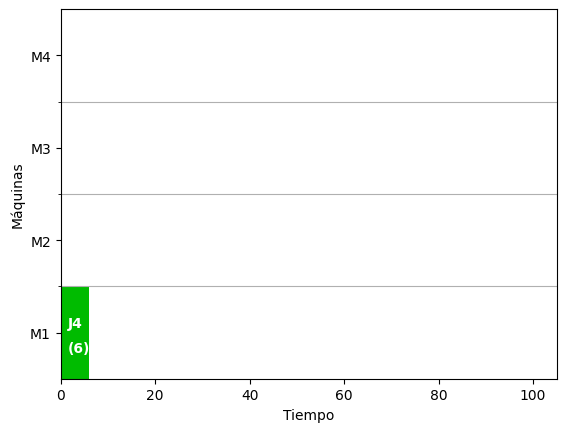

In [264]:
import matplotlib.pyplot as plt

unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i][j].varValue == 1]
orden_tareas = sorted(unos_tareas, key=lambda x: x[1])

ht = lp.value(model.objective)
nmaquinas = 4
hbar = 10
maquinas = ["M1", "M2", "M3", "M4"]

fig, gantt = plt.subplots()
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, ht)
gantt.set_ylim(0, nmaquinas * hbar)

gantt.set_yticks(np.arange(hbar, nmaquinas * hbar, hbar),minor=True)
gantt.grid(True, axis='y',which='minor')

gantt.set_yticks(np.arange(hbar/2, nmaquinas * hbar, hbar))
gantt.set_yticklabels(maquinas)

for i in range(M):
    inicio = lp.value(X[0][i])
    for j in range(N):
        duracion_tarea = T[orden_tareas[j][0]][i]
        if (j == 0): color = '#00BB00'
        if (j == 1): color = 'blue'
        if (j == 2): color = 'red'
        if (j == 3): color = '#EECC00'
        gantt.broken_barh([(inicio, duracion_tarea)], (i * hbar, hbar), facecolors=color)
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + hbar/3), s='('+str(duracion_tarea)+')', va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion_tarea/4), y=(i*hbar + 3*hbar/5), s='J'+str(1+orden_tareas[j][0]), va='center', color='white', fontweight='bold')
        inicio += duracion_tarea

#### Implemetación en CPLEX

#### Carta Gantt   

#### Implemetación en GUROBI

#### Carta Gantt   

### Modelo Wilson

### Modelo Manne

### Modelo Liao-You